# Flight Price Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Importing dataset

In [2]:
train_data = pd.read_excel(r"Data_Train.xlsx")
test_data = pd.read_excel(r"Test_set.xlsx")

In [3]:
train_data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


## Analyze data 

In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
train_data.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [6]:
train_data['Additional_Info'].value_counts()

No info                         8345
In-flight meal not included     1982
No check-in baggage included     320
1 Long layover                    19
Change airports                    7
Business class                     4
No Info                            3
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: Additional_Info, dtype: int64

In [7]:
train_data["Airline"].value_counts()

Jet Airways                          3849
IndiGo                               2053
Air India                            1752
Multiple carriers                    1196
SpiceJet                              818
Vistara                               479
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

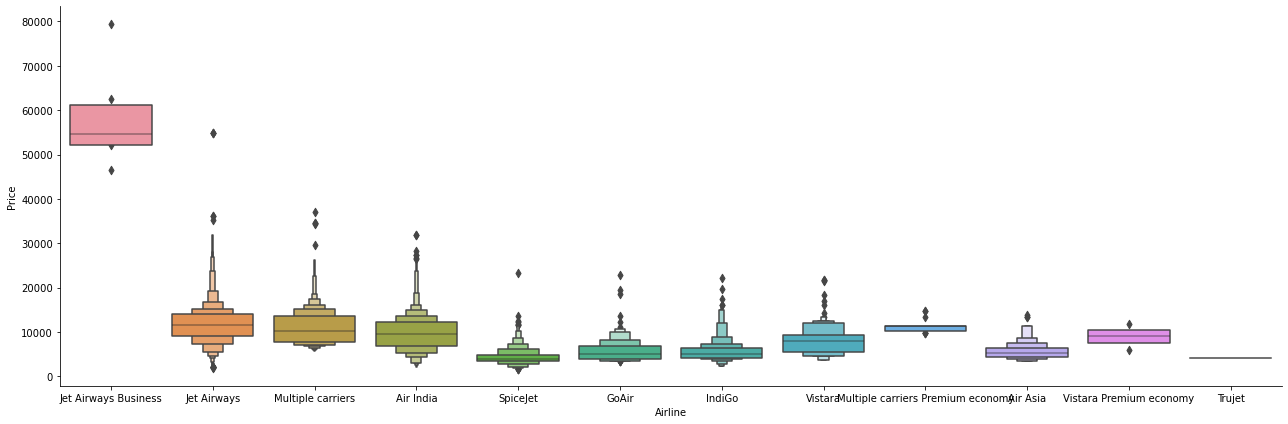

In [8]:
# From graph we can see that Jet Airways Business have the highest Price.
# Apart from the first Airline almost all are having similar median

# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [9]:
train_data["Source"].value_counts()

Delhi       4537
Kolkata     2871
Banglore    2197
Mumbai       697
Chennai      381
Name: Source, dtype: int64

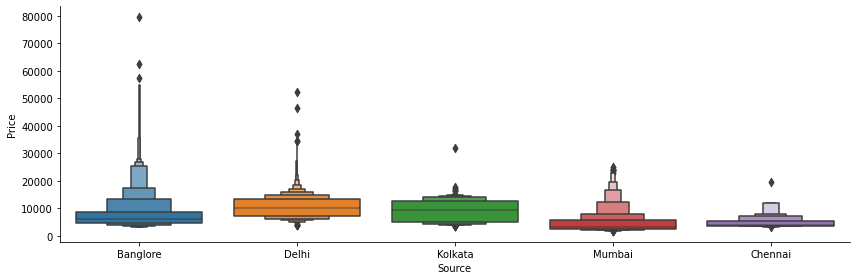

In [10]:
# Source vs Price

sns.catplot(y = "Price", x = "Source", data = train_data.sort_values("Price", ascending = False), kind="boxen", height = 4, aspect = 3)
plt.show()

In [11]:
train_data["Destination"].value_counts()

Cochin       4537
Banglore     2871
Delhi        1265
New Delhi     932
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

In [12]:
train_data["Total_Stops"].value_counts()

1 stop      5625
non-stop    3491
2 stops     1520
3 stops       45
4 stops        1
Name: Total_Stops, dtype: int64

---

## Preprocess data

In [13]:
def preprocessdata(data):
    
    data.dropna(inplace=True)
    # AS more than 80% of data is no info we can drop the column as it wont contribute much info
    data.drop(["Additional_Info"], axis = 1, inplace = True)
    
    # Seperate day, month and year for journey day
    data["Journey_day"] = pd.to_datetime(data["Date_of_Journey"], format="%d/%m/%Y").dt.day
    data["Journey_month"] = pd.to_datetime(data["Date_of_Journey"], format = "%d/%m/%Y").dt.month
    
    # Since we have converted Date_of_Journey column into integers, Now we can drop as it is of no use.
    data.drop(["Date_of_Journey"], axis = 1, inplace = True)

    # Extracting Hours
    data["Dep_hour"] = pd.to_datetime(data["Dep_Time"], format="%H:%M").dt.hour

    # Extracting Minutes
    data["Dep_min"] = pd.to_datetime(data["Dep_Time"], format="%H:%M").dt.minute

    # Now we can drop Dep_Time as it is of no use
    data.drop(["Dep_Time"], axis = 1, inplace = True)

    # Extracting Hours
    data["Arrival_hour"] = pd.to_datetime(data["Arrival_Time"]).dt.hour

    # Extracting Minutes
    data["Arrival_min"] = pd.to_datetime(data["Arrival_Time"]).dt.minute

    # Now we can drop Arrival_Time as it is of no use
    data.drop(["Arrival_Time"], axis = 1, inplace = True)

    durations = []
    for duration in data["Duration"] :
        hour_min = duration.split()
        if len(hour_min) == 2:
            durations.append(round(float(hour_min[0][:len(hour_min[0])-1]) + float(hour_min[1][:len(hour_min[1])-1])/60,2))
        elif "h" in hour_min[0]:
            durations.append(round(float(hour_min[0][:len(hour_min[0])-1]),2))
        elif "m" in hour_min[0]:
            durations.append(round(float(hour_min[0][:len(hour_min[0])-1])/60,2))
        
    data["Duration_hours"] = durations

    data.drop(["Duration"], axis = 1, inplace = True)
    
    data.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)

    # Concatenate dataframe --> data + Airline + Source + Destination

    data = pd.concat([data, 
                            pd.get_dummies(data[["Airline"]], drop_first= True), 
                            pd.get_dummies(data[["Source"]], drop_first= True), 
                            pd.get_dummies(data[["Destination"]], drop_first= True)], 
                            axis = 1)
    data.drop(["Airline", "Source", "Destination", "Route"], axis = 1, inplace = True)
    
    return data

In [14]:
train_data = preprocessdata(pd.read_excel(r"Data_Train.xlsx"))
test_data = preprocessdata(pd.read_excel(r"Test_set.xlsx"))

---

## Feature Selection

Finding out the best feature which will contribute and have good relation with target variable.
Following are some of the feature selection methods,


1. <span style="color: purple;">**heatmap**</span>
2. <span style="color: purple;">**feature_importance_**</span>
3. <span style="color: purple;">**SelectKBest**</span>

In [15]:
train_data.shape

(10682, 29)

In [16]:
train_data.columns

Index(['Total_Stops', 'Price', 'Journey_day', 'Journey_month', 'Dep_hour',
       'Dep_min', 'Arrival_hour', 'Arrival_min', 'Duration_hours',
       'Airline_Air India', 'Airline_GoAir', 'Airline_IndiGo',
       'Airline_Jet Airways', 'Airline_Jet Airways Business',
       'Airline_Multiple carriers',
       'Airline_Multiple carriers Premium economy', 'Airline_SpiceJet',
       'Airline_Trujet', 'Airline_Vistara', 'Airline_Vistara Premium economy',
       'Source_Chennai', 'Source_Delhi', 'Source_Kolkata', 'Source_Mumbai',
       'Destination_Cochin', 'Destination_Delhi', 'Destination_Hyderabad',
       'Destination_Kolkata', 'Destination_New Delhi'],
      dtype='object')

In [17]:
X = train_data.drop("Price",axis=1)
X.head()

,Total_Stops,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Airline_Air India,Airline_GoAir,...,Airline_Vistara Premium economy,Source_Chennai,Source_Delhi,Source_Kolkata,Source_Mumbai,Destination_Cochin,Destination_Delhi,Destination_Hyderabad,Destination_Kolkata,Destination_New Delhi
0,0,24,3,22,20,1,10,2.83,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2,1,5,5,50,13,15,7.42,1,0,...,0,0,0,1,0,0,0,0,0,0
2,2,9,6,9,25,4,25,19.00,0,0,...,0,0,1,0,0,1,0,0,0,0
3,1,12,5,18,5,23,30,5.42,0,0,...,0,0,0,1,0,0,0,0,0,0
4,1,1,3,16,50,21,35,4.75,0,0,...,0,0,0,0,0,0,0,0,0,1


In [18]:
y = train_data["Price"]
y.head()

0     3897
1     7662
2    13882
3     6218
4    13302
Name: Price, dtype: int64

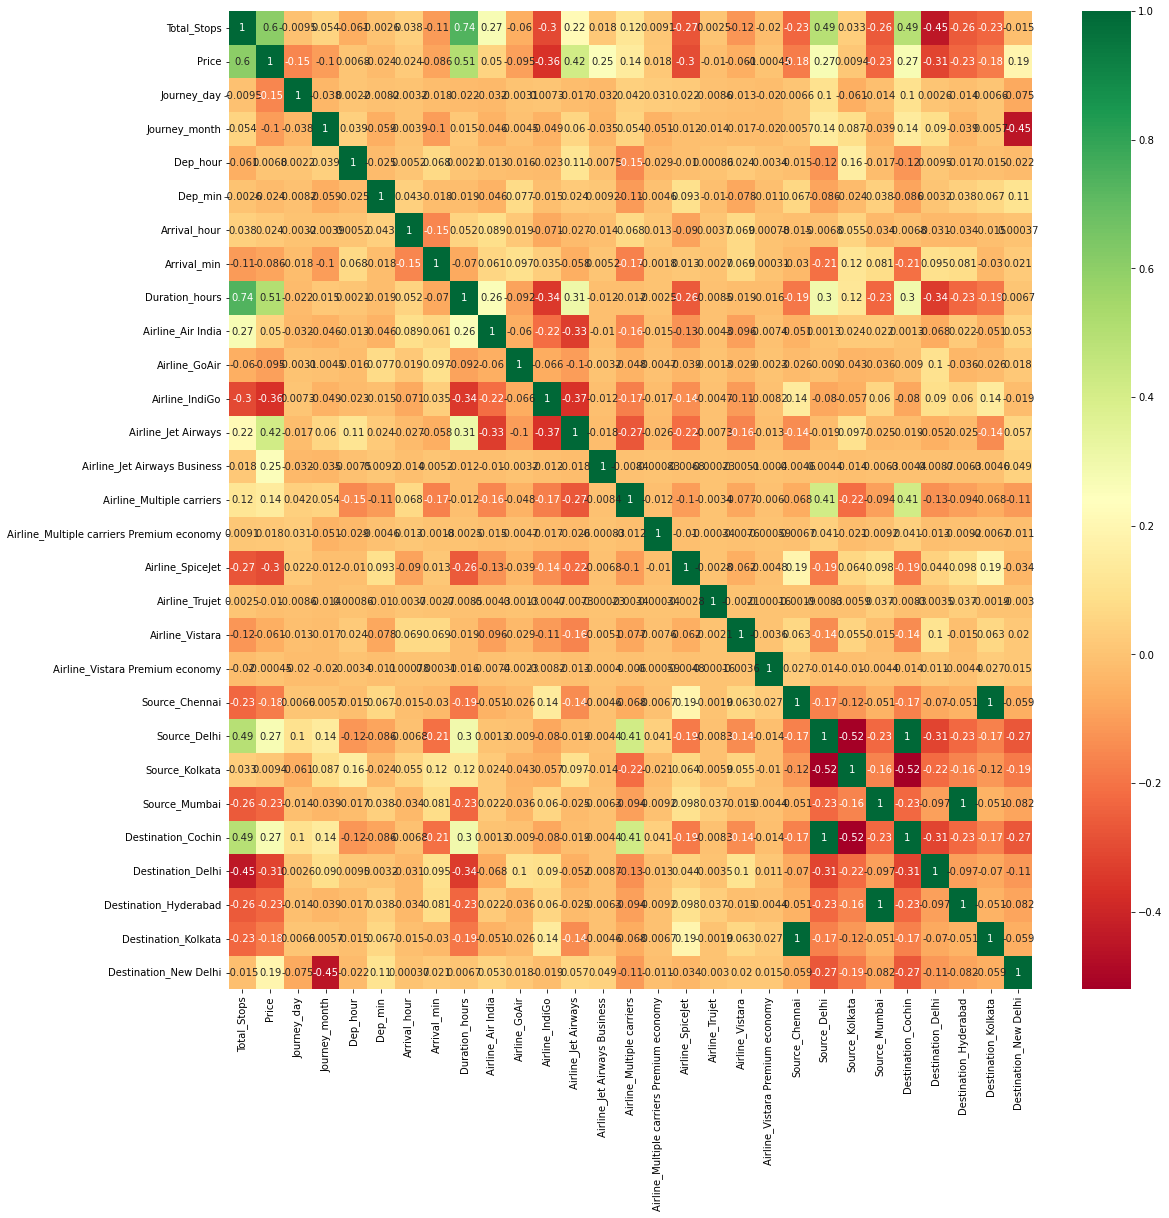

In [19]:
# Finds correlation between Independent and dependent attributes

plt.figure(figsize = (18,18))
sns.heatmap(train_data.corr(), annot = True, cmap = "RdYlGn")

plt.show()

In [20]:
# Important feature using ExtraTreesRegressor

from sklearn.ensemble import ExtraTreesRegressor
selection = ExtraTreesRegressor()
selection.fit(X, y)

ExtraTreesRegressor()

In [21]:
print(selection.feature_importances_)

[2.15577666e-01 1.43718155e-01 5.41897411e-02 2.61948666e-02
 2.57427751e-02 2.92103874e-02 2.25078357e-02 1.45104364e-01
 1.03072596e-02 1.78683820e-03 1.50392103e-02 1.38125358e-01
 6.75161918e-02 2.03945918e-02 8.35598017e-04 2.85709997e-03
 7.80050392e-05 5.32287670e-03 5.93007629e-05 5.40480387e-04
 9.90451726e-03 3.34669395e-03 5.60230816e-03 1.19291813e-02
 1.17305487e-02 7.34013774e-03 4.24849286e-04 2.46131627e-02]


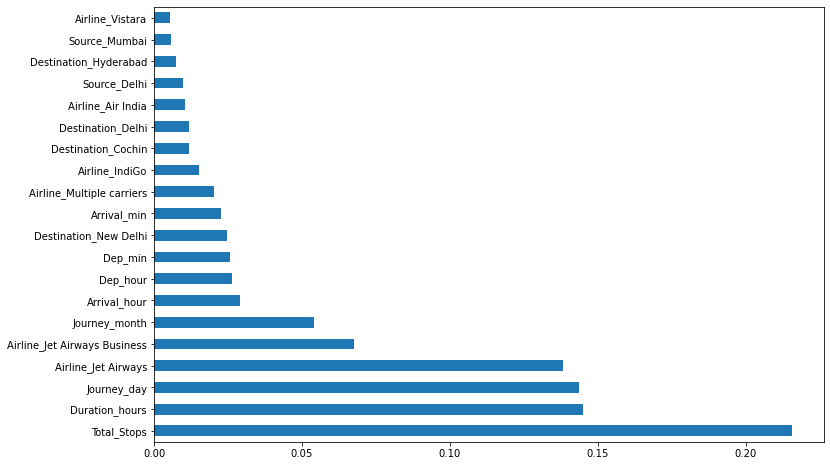

In [22]:
#plot graph of feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()


---

## Fitting model using Random Forest

1. Split dataset into train and test set in order to prediction w.r.t X_test
2. If needed do scaling of data
    * Scaling is not done in Random forest
3. Import model
4. Fit the data
5. Predict w.r.t X_test
6. In regression check **RSME** Score
7. Plot graph

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [24]:
from sklearn.ensemble import RandomForestRegressor
reg_rf = RandomForestRegressor()
reg_rf.fit(X_train, y_train)

RandomForestRegressor()

In [25]:
y_pred = reg_rf.predict(X_test)

In [26]:
reg_rf.score(X_train, y_train)

0.9528969289198291

In [27]:
reg_rf.score(X_test, y_test)

0.8133628469466372

C:\Users\krish\Softwares\anaconda3\envs\ml-venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


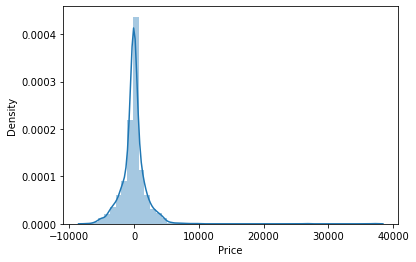

In [28]:
sns.distplot(y_test-y_pred)
plt.show()

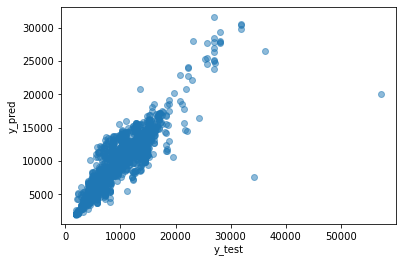

In [29]:

plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [30]:
from sklearn import metrics

In [31]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 1166.7107408046643
MSE: 4024280.806317812
RMSE: 2006.0610175958786


In [32]:
# RMSE/(max(DV)-min(DV))

2090.5509/(max(y)-min(y))

0.026887077025966846

In [33]:
metrics.r2_score(y_test, y_pred)

0.8133628469466372

---

## Hyperparameter Tuning


* Choose following method for hyperparameter tuning
    1. **RandomizedSearchCV** --> Fast
    2. **GridSearchCV**
* Assign hyperparameters in form of dictionery
* Fit the model
* Check best paramters and best score

In [34]:
from sklearn.model_selection import RandomizedSearchCV

In [35]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [36]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [37]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = reg_rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [38]:
rf_random.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   2.5s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   3.8s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [39]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [40]:
prediction = rf_random.predict(X_test)

C:\Users\krish\Softwares\anaconda3\envs\ml-venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


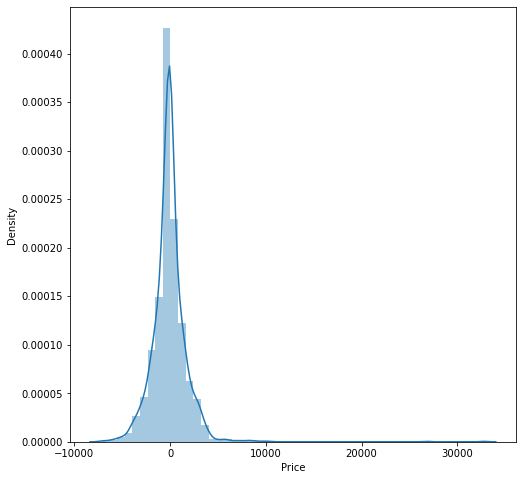

In [41]:
plt.figure(figsize = (8,8))
sns.distplot(y_test-prediction)
plt.show()

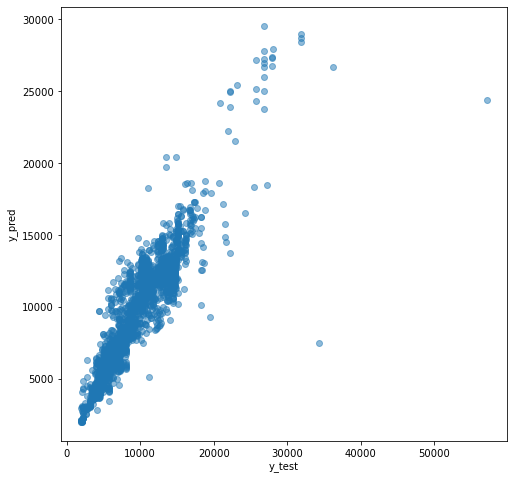

In [42]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

In [43]:
print('MAE:', metrics.mean_absolute_error(y_test, prediction))
print('MSE:', metrics.mean_squared_error(y_test, prediction))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, prediction)))

MAE: 1144.592576863005
MSE: 3536105.526952807
RMSE: 1880.453542886079


In [44]:
metrics.r2_score(y_test, prediction)

0.8360033257593176

---

## Save the model to reuse it again

In [50]:
import pickle
# open a file, where you ant to store the data
file = open('flight_rf.pkl', 'wb')

# dump information to that file
pickle.dump(rf_random, file)

In [51]:
model = open('flight_rf.pkl','rb')
forest = pickle.load(model)

In [52]:
y_prediction = forest.predict(X_test)

In [53]:
metrics.r2_score(y_test, y_prediction)

0.8360033257593176

---